In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import torch 

from IPython.display import display

In [2]:
torch.cuda.set_device(1)

In [3]:
PATH = os.path.abspath('../..')

# Helper methods for parsing and visualizing data

In [4]:
# note that these methods break if you use fastai v1.0
def parse_csv_multi_class_values(path_to_csv):
    """Parse filenames and values for classes from a CSV file.

    This method expects that the csv file at path :fn: has one column for filenames,
    while all the other columns represent classes.
    Expects a header with class names

    Arguments:
        path_to_csv: Path to a CSV file.

    Returns:
        a three-tuple of:            
            a list of filenames
            a list of values in the same order
            a dictionary of classes by class_index           
    """
    with open(path_to_csv) as fileobj:
        reader = csv.reader(fileobj)
        header = next(reader)
        csv_lines = [l for l in reader]

    fnames = [fname for fname, *_ in csv_lines]
    classes = header[1:]
    values = [vals for _, *vals in csv_lines]
    idx2class = {i:c for i, c in enumerate(classes)}
   
    return fnames, values, idx2class

def csv_source_multi_class(folder, csv_file, suffix=''):
    fnames, values, idx2class = parse_csv_multi_class_values(csv_file)
    full_names = [os.path.join(folder,fn+suffix) for fn in fnames]
   
    val_arr = np.array(values).astype(np.float32)
    
    return full_names, val_arr, idx2class

@classmethod
def from_multiclass_csv(cls, path, folder, csv_fname, bs=64, tfms=(None,None),
           val_idxs=None, suffix='', test_name=None, num_workers=8):
    """ Read in images and their labels given as a CSV file.
--
    This method should be used when training image labels are given in an CSV file as opposed to
    sub-directories with label names.

    Arguments:
        path: a root path of the data (used for storing trained models, precomputed values, etc)
        folder: a name of the folder in which training images are contained.
        csv_fname: a name of the CSV file which contains target labels.
        bs: batch size
        tfms: transformations (for data augmentations). e.g. output of `tfms_from_model`
        val_idxs: index of images to be used for validation. e.g. output of `get_cv_idxs`.
            If None, default arguments to get_cv_idxs are used.
        suffix: suffix to add to image names in CSV file (sometimes CSV only contains the file name without file
                extension e.g. '.jpg' - in which case, you can set suffix as '.jpg')
        test_name: a name of the folder which contains test images.
        skip_header: skip the first row of the CSV file.
        num_workers: number of workers

    Returns:
        ImageClassifierData
    """
    fnames,y,idx2class = csv_source_multi_class(folder, csv_fname, suffix)

    val_idxs = get_cv_idxs(len(fnames)) if val_idxs is None else val_idxs
    ((val_fnames,trn_fnames),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames), y)

    test_fnames = read_dir(path, test_name) if test_name else None
    
    f = FilesIndexArrayRegressionDataset
    datasets = cls.get_ds(f, (trn_fnames,trn_y), (val_fnames,val_y), tfms,
                           path=path, test=test_fnames)
    return cls(path, datasets, bs, num_workers, classes=list(idx2class.values()))

ImageClassifierData.from_multiclass_csv = from_multiclass_csv

In [9]:
def load_image(idx, df, ax=None, annotate=True):
    """Helper function to load and annotate image"""
    
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
        
    Z_true, Z_pred = df.iloc[idx]
    name = df.index[idx]
    
    # get image
    image = plt.imread(f'{PATH}/test/{name}.jpg')
    ax.imshow(image)
    ax.axis('off')
    
    # label
    if annotate:
        fontdict = dict(color='white', size=18)
        #ax.text(0.5, 0.9, f'{name}', fontdict=fontdict, transform=ax.transAxes, ha='center', va='bottom')
        ax.text(0.95, 0.125, r'$Z_{\rm true}$' + f' = {Z_true:.3f}', fontdict=fontdict, transform=ax.transAxes, ha='right', va='bottom')
        ax.text(0.95, 0.025, r'$Z_{\rm pred}$' + f' = {Z_pred:.3f}', fontdict=fontdict, transform=ax.transAxes, ha='right', va='bottom')

In [10]:
# basically the figure that I made in my paper
def plot_comparison_with_marginals(y_test, p_test):
    
    gs = matplotlib.gridspec.GridSpec(20, 20)
    
    fig = plt.figure(figsize=(8, 8))
    
    ax = fig.add_subplot(gs[4:, 2:18])
    
    # plot main histogram
    *_, im = ax.hist2d(y_test, p_test, bins=100, range=[[8.2, 9.3], [8.2, 9.3]], cmap='cubehelix_r', norm=matplotlib.colors.LogNorm(vmin=1, vmax=100), alpha=1)
    ax.plot([8.2, 9.3], [8.2, 9.3], c='k', ls='--', lw=3)
    
    ax.set_xlabel(r'$Z_{\rm true}$', fontsize=18)
    ax.set_ylabel(r'$Z_{\rm pred}$', fontsize=18)
        
    # add colorbar
    ax_cb = fig.add_subplot(gs[4:, 19:])
    cb = fig.colorbar(im, cax=ax_cb);
    cb.set_label('Number', fontsize=14)
    
    # add top margin plot
    ax_marg = fig.add_subplot(gs[:4, 2:18])

    y_bins = np.linspace(8.3, 9.2, 10)
    rmse_bins = [np.sqrt(np.mean(((p_test - y_test)[(y_test > y - 0.05) & (y_test < y + 0.05)])**2)) for y in y_bins]
    num_in_bins = np.sum([(y_test > y - 0.05) & (y_test < y + 0.05) for y in y_bins], axis=1)
    rmse_error = rmse_np(p_test, y_test)
    ax_marg.scatter(y_bins, rmse_bins, marker='o', c='C0', s=num_in_bins/30, label=f'<RMSE>={rmse_error:.4f}')

    nmad_bins = [np.sqrt(nmad(((p_test - y_test)[(y_test > y - 0.05) & (y_test < y + 0.05)])**2)) for y in y_bins]
    nmad_error = nmad(p_test - y_test)
    ax_marg.scatter(y_bins, nmad_bins, marker='o', c='C1', s=num_in_bins/30, label=f'<NMAD>={nmad_error:.4f}')
    
    ax_marg.set_ylabel('Scatter', fontsize=14)
    ax_marg.legend(fontsize=12, framealpha=0.0, frameon=False)
    ax_marg.set_ylim(0, 0.3)
    ax_marg.set_xlim(8.2, 9.3)
    ax_marg.set_xticklabels([])
    
    # include mean RMSE  
    ax_marg.axhline(rmse_error, ls='-', c='C0')
    ax_marg.axhline(nmad_error, ls='-', c='C1')
        
def rmse_np(x, y):
    return np.sqrt(np.mean((y - x)**2))

def nmad(z, const=1.4826):
    """Returns the Gaussian sigma according to MAD"""
    return const*np.median(np.abs(z - np.median(z)))

# Constructing a learner

In [5]:
train_label_csv = f'{PATH}/catalogs/train-oh_p50.csv'
df = pd.read_csv(train_label_csv, index_col=0)

n = len(df)
val_idxs = get_cv_idxs(n)


In [6]:
def get_data(arch, sz, bs, val_idxs=val_idxs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    return ImageClassifierData.from_multiclass_csv(PATH, 'train', train_label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=16)

def rmse(x, y):
    return torch.sqrt(F.mse_loss(x,y))

In [7]:
# params
sz = 128
bs = 128
arch = resnet34

In [8]:
data = get_data(arch, sz, bs, val_idxs=val_idxs)

learn = ConvLearner.pretrained(arch, data)
metrics = [rmse]
learn.crit = rmse

# fastai representation

In [9]:
display(learn.model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

In [10]:
display(learn.summary)

<bound method ConvLearner.summary of Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),

# Pytorch representation of a basic CNN net
Inspired by a [notebook](https://github.com/richardagalvez/basic-intro-pytorch) by R. Galavez

In [20]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(32*32*32, 1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [21]:
arch = SimpleCNN()

In [24]:
tfms = tfms_from_model(arch, 128, aug_tfms=transforms_top_down, max_zoom=1.05)
data = ImageClassifierData.from_multiclass_csv(PATH, 'train', train_label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=16)

In [25]:
learn = ConvLearner.from_model_data(arch, data)
learn.crit = rmse

In [26]:
learn, [o.numel() for o in learn.model.parameters()]

(SimpleCNN(
   (layer1): Sequential(
     (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
     (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
     (2): ReLU()
     (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
   )
   (layer2): Sequential(
     (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
     (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
     (2): ReLU()
     (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
   )
   (fc): Linear(in_features=32768, out_features=1, bias=True)
 ), [1200, 16, 16, 16, 12800, 32, 32, 32, 32768, 1])

 46%|████▌     | 553/1200 [00:35<00:41, 15.46it/s, loss=1.53] 

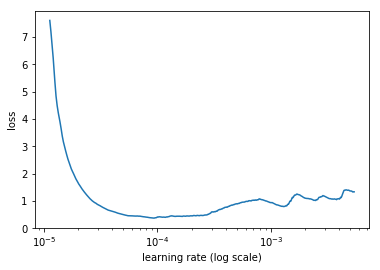

In [27]:
learn.lr_find()
learn.sched.plot()

# Training this shallow convnet
(My hyperparameters are probably garbage)

epoch      trn_loss   val_loss                                 
    0      0.206244   0.132968  


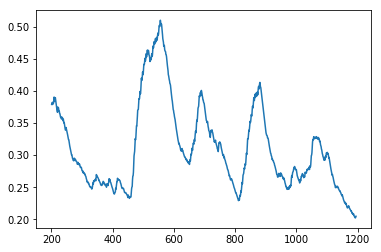

In [28]:
learn.fit(1e-4, 1, wds=1e-6)
learn.sched.plot_loss(n_skip=200)

epoch      trn_loss   val_loss                                 
    0      0.162029   0.153086  
    1      0.147016   0.120464                                 


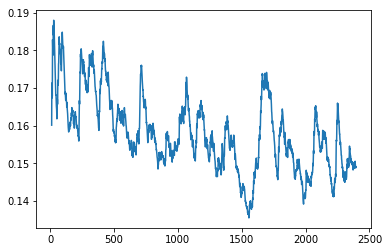

In [29]:
learn.fit(3e-5, 2, wds=1e-6)
learn.sched.plot_loss()

epoch      trn_loss   val_loss                                 
    0      0.12612    0.116602  
    1      0.129533   0.113591                                 
    2      0.125341   0.121554                                 
    3      0.128197   0.113072                                 


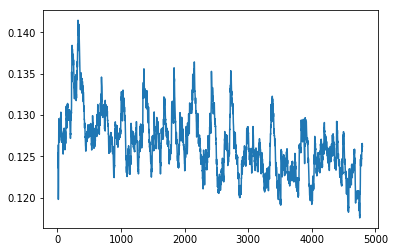

In [30]:
learn.fit(1e-5, 4, wds=1e-6)
learn.sched.plot_loss()

# Make predictions

In [23]:
# run test (no augmentation)
Z_pred = learn.predict(is_test=True)

In [24]:
# answer key
test_names = np.array([os.path.split(fname)[1][:-4] for fname in learn.data.test_ds.fnames], dtype=np.int64)
df_test = pd.read_csv(f'{PATH}/catalogs/test-oh_p50.csv', index_col=0)
Z_true = df_test.loc[test_names].values

In [25]:
# concatenate
preds = pd.DataFrame({'Z_pred': Z_pred.flatten(), 'Z_true': Z_true.flatten()}, index=test_names)

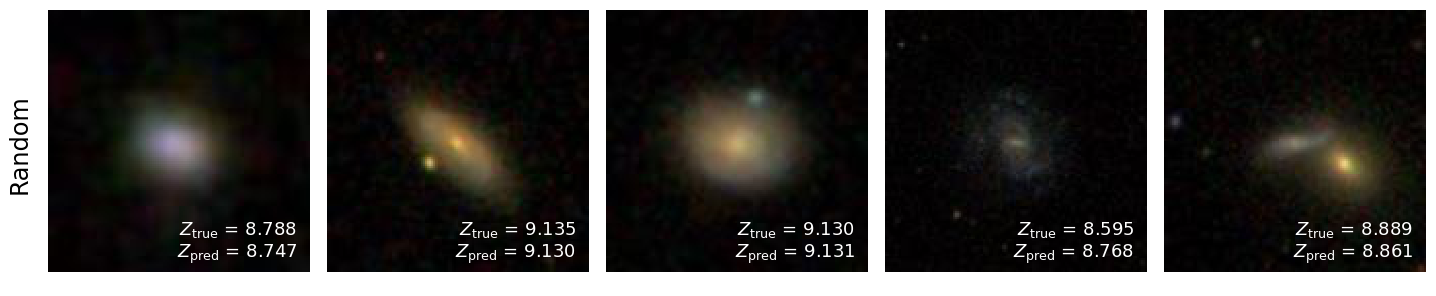

In [35]:
# random selection
rand = preds.sample(frac=1., random_state=1234)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for idx in range(5):
    ax = axes.flat[idx]
    load_image(idx, rand, ax=ax)
    
fig.tight_layout()
fig.subplots_adjust(wspace=0.03, hspace=0.03)
fig.text(0, 0.5, r'Random', rotation=90, fontsize=24, va='center');

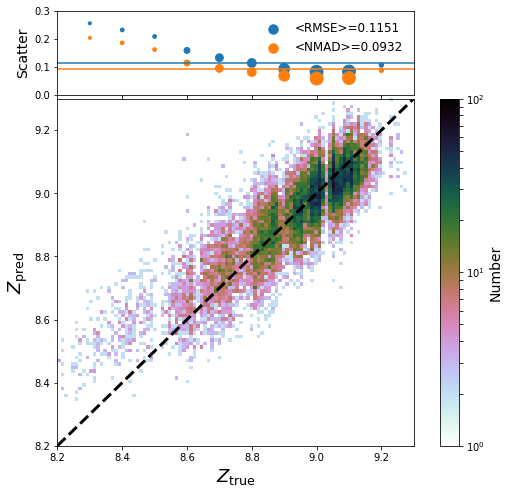

In [37]:
plot_comparison_with_marginals(Z_true.flatten(), Z_pred.flatten())

# A deeper convnet
Inspired by the [fastai notebook](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson7-cifar10.ipynb)

In [38]:
class ConvBnNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(layers[i], layers[i + 1], kernel_size=5, padding=2),
                nn.BatchNorm2d(layers[i + 1]),
                nn.ReLU())
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], 1)
        
    def forward(self, x):
        x = self.conv1(x)
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return self.out(x).view(-1)

In [39]:
arch = ConvBnNet([16, 32, 64, 128])
tfms = tfms_from_model(arch, 128, aug_tfms=transforms_top_down, max_zoom=1.05)
data = ImageClassifierData.from_multiclass_csv(PATH, 'train', train_label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=16)

learn = ConvLearner.from_model_data(arch, data)
learn.crit = rmse

In [40]:
learn, [o.numel() for o in learn.model.parameters()]

(ConvBnNet(
   (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
   (layers): ModuleList(
     (0): Sequential(
       (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
       (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
       (2): ReLU()
     )
     (1): Sequential(
       (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
       (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
       (2): ReLU()
     )
     (2): Sequential(
       (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
       (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
       (2): ReLU()
     )
   )
   (out): Linear(in_features=128, out_features=1, bias=True)
 ),
 [1200,
  16,
  12800,
  32,
  32,
  32,
  51200,
  64,
  64,
  64,
  204800,
  128,
  128,
  128,
  128,
  1])

In [41]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 16, 128, 128]),
                           ('trainable', True),
                           ('nb_params', 1216)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 16, 128, 128]),
                           ('output_shape', [-1, 32, 128, 128]),
                           ('trainable', True),
                           ('nb_params', 12832)])),
             ('BatchNorm2d-3',
              OrderedDict([('input_shape', [-1, 32, 128, 128]),
                           ('output_shape', [-1, 32, 128, 128]),
                           ('trainable', True),
                           ('nb_params', 64)])),
             ('ReLU-4',
              OrderedDict([('input_shape', [-1, 32, 128, 128]),
                           ('output_shape', [-1, 32, 128, 128]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
        

 49%|████▊     | 583/1200 [02:05<02:12,  4.64it/s, loss=1.12] 

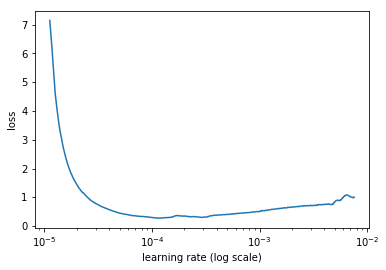

In [43]:
learn.lr_find()
learn.sched.plot()

epoch      trn_loss   val_loss                                 
    0      0.171818   0.1194    
    1      0.146403   0.125567                                 


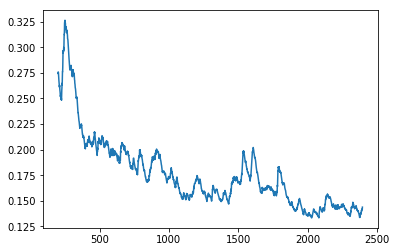

In [44]:
learn.fit(3e-4, 2, wds=1e-6)
learn.sched.plot_loss(n_skip=200)

epoch      trn_loss   val_loss                                 
    0      0.115088   0.110318  


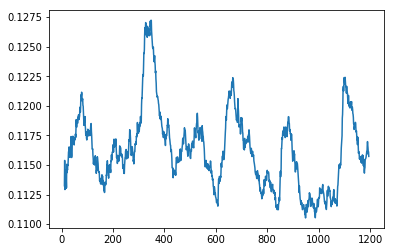

In [45]:
learn.fit(1e-4, 1)
learn.sched.plot_loss()

epoch      trn_loss   val_loss                                 
    0      0.111635   0.11041   


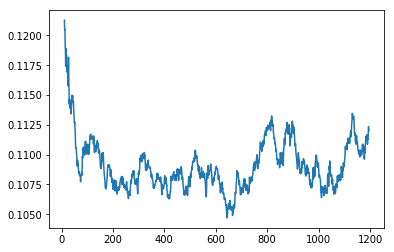

In [46]:
learn.fit(3e-5, 1, wds=1e-6)
learn.sched.plot_loss()

In [47]:
Z_pred = learn.predict(is_test=True)
preds = pd.DataFrame({'Z_pred': Z_pred.flatten(), 'Z_true': Z_true.flatten()}, index=test_names)

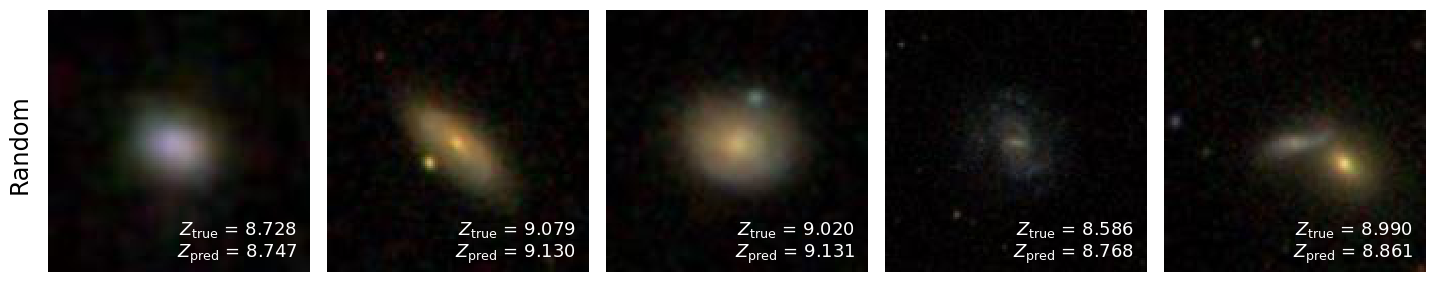

In [48]:
# same random galaxies as before
rand = preds.sample(frac=1., random_state=1234)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for idx in range(5):
    ax = axes.flat[idx]
    load_image(idx, rand, ax=ax)
    
fig.tight_layout()
fig.subplots_adjust(wspace=0.03, hspace=0.03)
fig.text(0, 0.5, r'Random', rotation=90, fontsize=24, va='center');

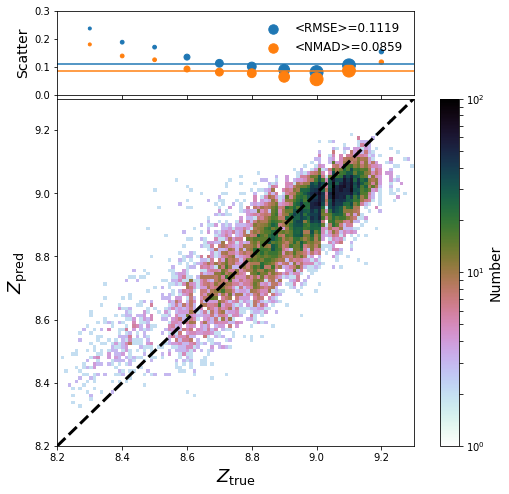

In [49]:
plot_comparison_with_marginals(Z_true.flatten(), Z_pred.flatten())

# A simple resnet

In [50]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a
    


In [51]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [60]:
class Resnet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.conv1 = nn.Conv2d(3, layers[0], kernel_size=7, stride=2, padding=3)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], 1)
        self.drop = nn.Dropout(0.25)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        return self.out(x).view(-1)

In [61]:
arch = Resnet([16, 32, 64, 128])
tfms = tfms_from_model(arch, 128, aug_tfms=transforms_top_down, max_zoom=1.05)
data = ImageClassifierData.from_multiclass_csv(PATH, 'train', train_label_csv, tfms=tfms,
                    bs=128, suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=16)

learn = ConvLearner.from_model_data(arch, data)
learn.crit = rmse

In [62]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 16, 64, 64]),
                           ('trainable', True),
                           ('nb_params', 2368)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 16, 64, 64]),
                           ('output_shape', [-1, 32, 32, 32]),
                           ('trainable', True),
                           ('nb_params', 4608)])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 16, 64, 64]),
                           ('output_shape', [-1, 32, 32, 32]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 32, 32, 32]),
                           ('output_shape', [-1, 32, 32, 32]),
                           ('trainable', True),
                           ('nb_params', 9216)])),
             ('ResnetLayer-5',
              Orde

In [64]:
learn, np.sum([o.numel() for o in learn.model.parameters()])

(Resnet(
   (conv1): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
   (layers): ModuleList(
     (0): BnLayer(
       (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     )
     (1): BnLayer(
       (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     )
     (2): BnLayer(
       (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     )
   )
   (layers2): ModuleList(
     (0): ResnetLayer(
       (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     )
     (1): ResnetLayer(
       (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     )
     (2): ResnetLayer(
       (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     )
   )
   (layers3): ModuleList(
     (0): ResnetLayer(
       (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1

 69%|██████▊   | 412/600 [01:09<00:31,  5.93it/s, loss=nan] 

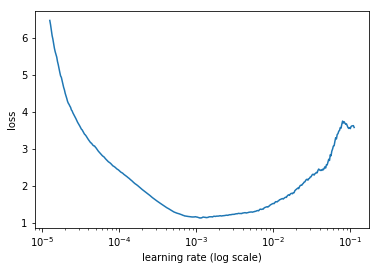

In [65]:
learn.lr_find()
learn.sched.plot()

epoch      trn_loss   val_loss                               
    0      0.510412   0.243697  
    1      0.494217   0.166628                               


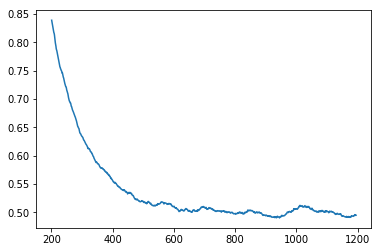

In [66]:
learn.fit(1e-4, 2, wds=1e-6)
learn.sched.plot_loss(n_skip=200)

epoch      trn_loss   val_loss                               
    0      0.480234   0.175858  


epoch      trn_loss   val_loss                               
    0      0.483899   0.153152  


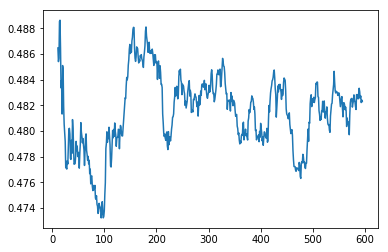

In [68]:
learn.fit(3e-5, 1)
learn.fit(1e-5, 1)
learn.sched.plot_loss()

In [69]:
Z_pred = learn.predict(is_test=True)

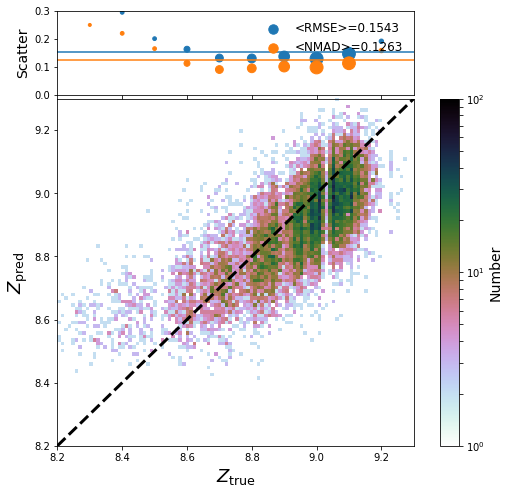

In [70]:
plot_comparison_with_marginals(Z_true.flatten(), Z_pred.flatten())

# Using fastai resnet architecture

In [71]:
arch = resnet18
data = get_data(arch, sz=128, bs=128, val_idxs=val_idxs)

learn = ConvLearner.pretrained(resnet18, data, precompute=False, pretrained=False)
learn.crit = rmse

 82%|████████▏ | 984/1200 [01:16<00:16, 12.93it/s, loss=2.32] 

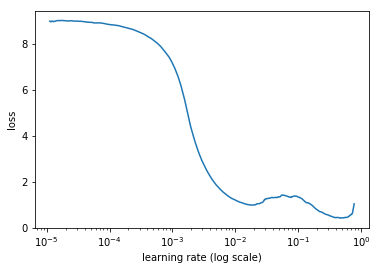

In [72]:
learn.lr_find()
learn.sched.plot()

In [74]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 32, 32]),
      

epoch      trn_loss   val_loss                                 
    0      0.350796   0.296681  
    1      0.212512   0.169632                                 


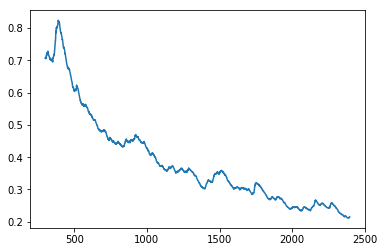

In [73]:
learn.fit(1e-2, 2)
learn.sched.plot_loss(n_skip=300)

In [75]:
learn.unfreeze()

epoch      trn_loss   val_loss                                 
    0      0.147578   0.115145  
    1      0.129574   0.11138                                  


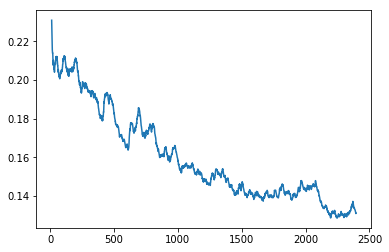

In [76]:
learn.fit(1e-2, 2)
learn.sched.plot_loss()

epoch      trn_loss   val_loss                                 
    0      0.109593   0.099061  
    1      0.113171   0.096542                                 


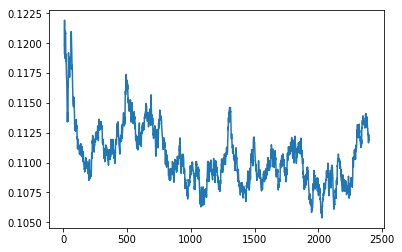

In [77]:
learn.fit(3e-3, 2)
learn.sched.plot_loss()

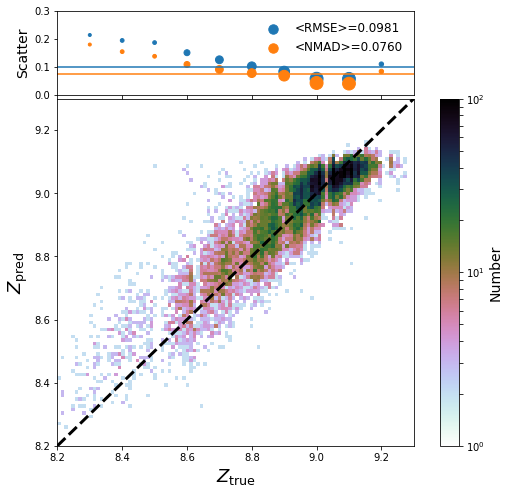

In [78]:
Z_pred, _ = learn.TTA(is_test=True)
Z_pred = Z_pred.mean(axis=0)
plot_comparison_with_marginals(Z_true.flatten(), Z_pred.flatten())

RMSE about 0.1 dex in only six epochs of training from scratch.

# Using fastai pretrained resnet

In [11]:
arch = resnet18

tfms = tfms_from_model(arch, 128, aug_tfms=transforms_top_down, max_zoom=1.05)
data = ImageClassifierData.from_multiclass_csv(PATH, 'train', train_label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=16, bs=128)

In [15]:
learn = ConvLearner.pretrained(resnet18, data, precompute=True, pretrained=True)
learn.crit = rmse

 87%|████████▋ | 523/600 [00:09<00:01, 57.02it/s, loss=5.41]


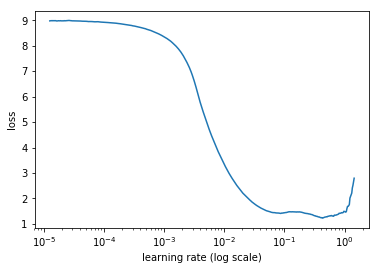

In [16]:
learn.lr_find()
learn.sched.plot()

epoch      trn_loss   val_loss                               
    0      0.390427   0.202393  
    1      0.265123   0.185584                               
    2      0.227933   0.19944                                
    3      0.209089   0.165692                               
    4      0.207041   0.165811                               
    5      0.192962   0.158029                               
    6      0.188552   0.160821                               



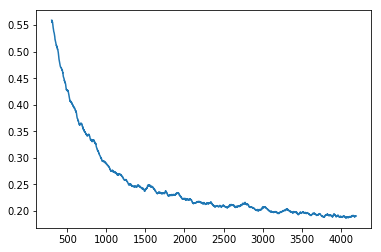

In [17]:
learn.fit(1e-2, 3, cycle_mult=2)
learn.sched.plot_loss(n_skip=300)

Note that this takes 10 seconds per epoch because of the precomputed (i.e., frozen) activations in the early layers

In [18]:
learn.unfreeze()

epoch      trn_loss   val_loss                               
    0      0.185569   0.155869  
    1      0.179808   0.154978                               



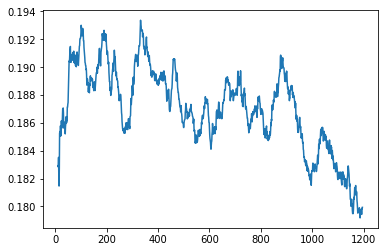

In [19]:
learn.fit([1e-4, 1e-3, 1e-2], 2)
learn.sched.plot_loss()

epoch      trn_loss   val_loss                               
    0      0.156075   0.141849  
    1      0.152234   0.141026                               



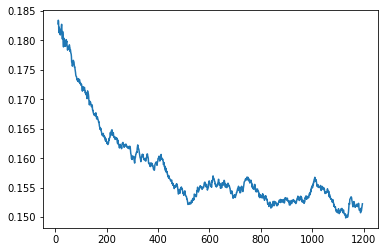

In [20]:
learn.fit([1e-5, 3e-5, 1e-4], 2)
learn.sched.plot_loss()

In [ ]:
Z_pred, _ = learn.TTA(is_test=True)
Z_pred = Z_pred.mean(axis=0)
plot_comparison_with_marginals(Z_true.flatten(), Z_pred.flatten())

 50%|█████     | 2/4 [00:37<00:37, 18.96s/it]